# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 19: Mean Entropic Drawdown at Risk (EDaR) Optimization

## 1. Downloading the data:

In [1]:
# pip install yfinance riskfolio-lib Mosek pybind11


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2022-03-19'

# Tickers of assets

assets = ['NVDA', 'KNSL',  'CRWD', 'AVGO', 'MDB', 'SNOW', 'FTNT', 'NET', 
          'CDNS', 'TSM', 'CSU.TO', 'MSFT', 'AAPL', 'META', 'ADBE',
          'MA', 'MSCI',  'COKE', 'NVO', 'LLY', 'V', 'PLTR', 'ZS', 'HRMY',
          'TSLA', 'SMCI', 'CMG', 'NFLX', 'FAST',  'WM', 'SHOP']

assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
# data = data.resample('M').last()

data.columns = assets

[*********************100%%**********************]  31 of 31 completed


In [3]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

,AAPL,ADBE,AVGO,CDNS,CMG,COKE,CRWD,CSU.TO,FAST,FTNT,...,NVO,PLTR,SHOP,SMCI,SNOW,TSLA,TSM,V,WM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01,0.8462%,1.8514%,1.1748%,1.8756%,-0.4575%,-0.5692%,4.0416%,3.4759%,-0.7319%,2.0711%,...,-0.2592%,-0.4211%,3.0754%,-0.9091%,-3.0040%,4.4638%,1.9119%,1.6902%,-0.2474%,2.5624%
2020-10-02,-3.2280%,-4.1080%,-3.1932%,-3.0470%,1.3554%,1.3748%,-2.0998%,-0.1940%,-0.4915%,-3.2183%,...,-0.8520%,-2.7484%,-2.4127%,-1.2615%,-6.7198%,-7.3791%,-2.2029%,-0.9294%,0.8858%,-1.5558%
2020-10-05,3.0791%,1.5616%,2.5979%,2.0319%,-0.1427%,0.0000%,3.5819%,0.9836%,2.8963%,2.3286%,...,2.1264%,-1.8478%,3.5511%,3.6005%,5.6803%,2.5513%,4.6287%,1.0325%,0.3073%,2.2950%
2020-10-06,-2.8670%,-1.5397%,-0.5791%,-1.8053%,0.2713%,0.0082%,0.1726%,-1.4231%,-1.5274%,-0.6634%,...,-1.3691%,9.6346%,-2.2787%,-0.9342%,2.1250%,-2.7485%,-1.6797%,-1.5181%,-0.8666%,0.1376%
2020-10-07,1.6967%,2.9584%,0.7583%,2.7673%,1.7725%,-1.1953%,-0.3859%,0.3694%,2.3931%,2.0203%,...,-0.6940%,1.0101%,3.0905%,1.9615%,0.3672%,2.7344%,4.5717%,1.0077%,0.5563%,1.4913%


## 2. Estimating Mean EDaR Portfolios

### 2.1 Calculating the portfolio that maximizes Return/EDaR ratio.

The Entropic Drawdown at Risk (EDaR) is a risk measure derived from Entropic Value at Risk, that I developed when you apply the EVaR to drawdowns distribution:

$$
\begin{aligned}
\text{EVaR}_{\alpha}(X) & = \inf_{z>0} \left \{z\log \left ( \frac{1}{\alpha} M_{\text{DD}(X)} (\frac{1}{z}) \right ) \right \} \\
\text{DD}(X,j) & = \max_{t \in (0,j)} \left ( \sum_{i=0}^{t}X_{i} \right )- \sum_{i=0}^{j}X_{i} \\
\end{aligned}
$$

Where $M_{X} (t) = \text{E} [e^{tX}]$ is the moment generating function and $\alpha \in [0,1]$ is the significance level.
    
In a similar way than Markowitz model, the mean EDaR model can be expressed as one of the following problems:

$$
\begin{aligned}
& \min_{w,\, z} & & \mu w - \lambda \text{EDaR}_{\alpha}(r w)\\
& & & 1^{T}w = 1 \\
& & & w \geq 0 \\
\end{aligned}
$$

$$
\begin{aligned}
& \max_{w,\, z} & & \frac{\mu w - r_{f}}{\lambda \text{EDaR}_{\alpha}(r w)}\\
& & & 1^{T}w = 1 \\
& & & w \geq 0 \\
\end{aligned}
$$

$$
\begin{aligned}
& \min_{w,\, z} & & \text{EDaR}_{\alpha}(r w)\\
& & & 1^{T}w = 1 \\
& & & w \geq 0 \\
\end{aligned}
$$

Where $z$ is the factor of EDaR, $w$ are the weights of assets, $\mu$ is the mean vector, $\lambda$ is the risk aversion factor, $r$ is the returns matrix and $r_{f}$ the risk free rate.

It is recommended to use MOSEK to optimize EDaR, due to it requires exponential cone programming to solve the problem.

Instructions to install MOSEK are in this __[link](https://docs.mosek.com/9.2/install/installation.html)__, is better to install using Anaconda. Also you will need a license, I recommend you that ask for an academic license __[here](https://www.mosek.com/products/academic-licenses/)__.

In [4]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.
method_kurt='hist'

port.assets_stats(method_mu=method_mu, method_cov=method_cov, method_kurt=method_kurt, d=0.94)

# Estimate optimal portfolio:

# port.solvers = ['MOSEK'] # It is recommended to use mosek when optimizing EVaR 
port.alpha = 0.01 # Significance level for CVaR, EVaR y CDaR 
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'EDaR' # Risk measure used, this time will be EVaR
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,AAPL,ADBE,AVGO,CDNS,CMG,COKE,CRWD,CSU.TO,FAST,FTNT,...,NVO,PLTR,SHOP,SMCI,SNOW,TSLA,TSM,V,WM,ZS
weights,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,6.7422%,0.0000%,0.0000%,0.0000%,10.7631%,...,0.0000%,0.0000%,0.0000%,0.4741%,0.0000%,0.0000%,31.8871%,0.0000%,0.0000%,0.0000%


### 2.2 Plotting portfolio composition

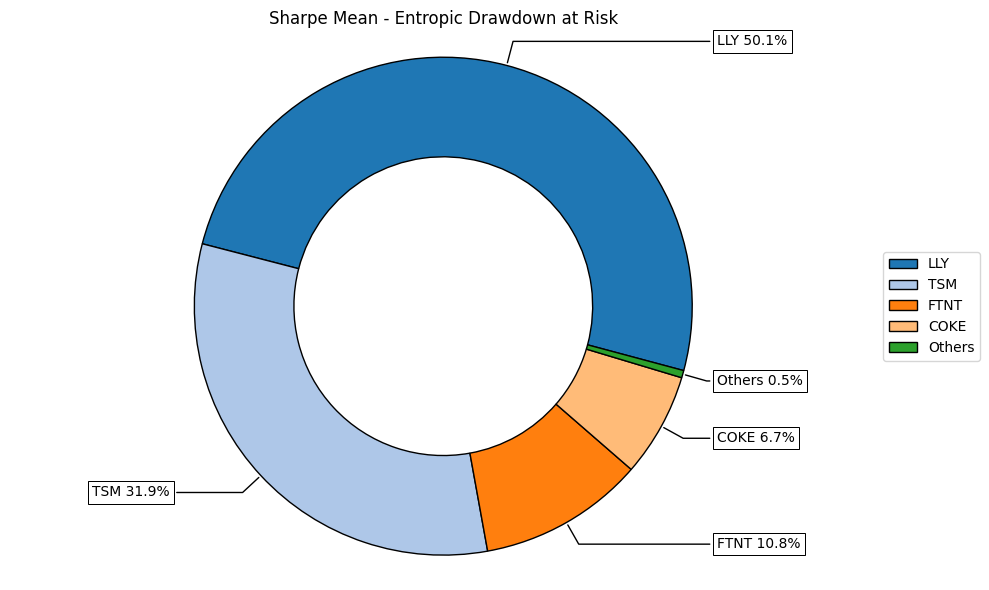

In [5]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean - Entropic Drawdown at Risk', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 2.3 Plotting risk measures

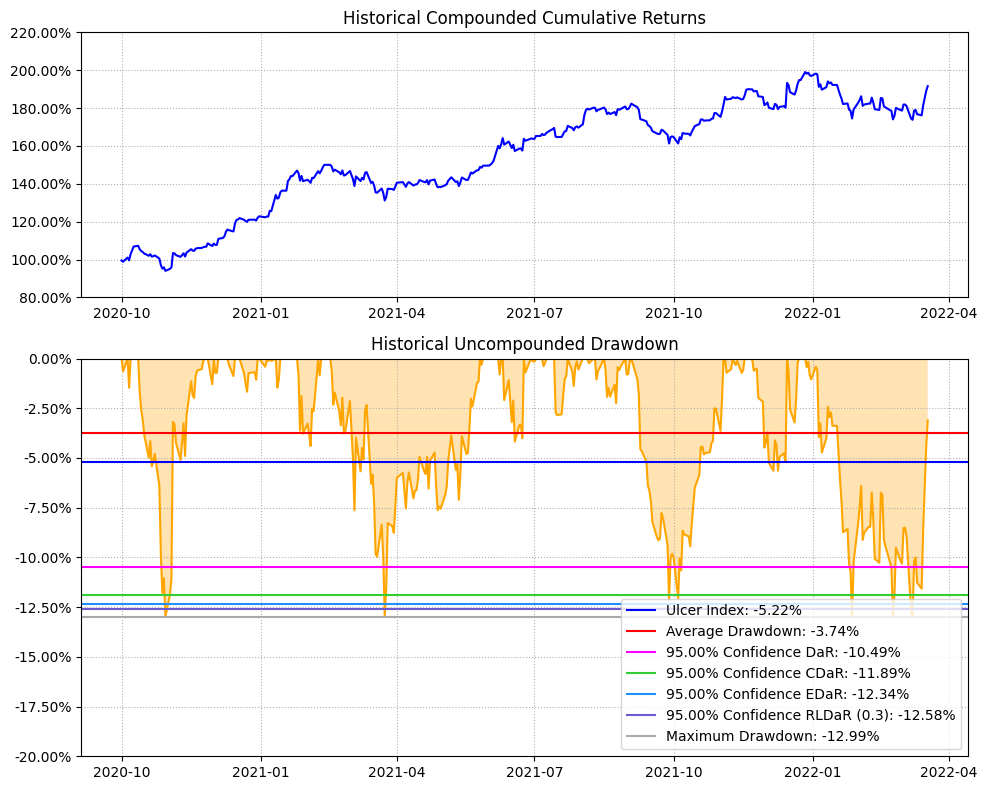

In [6]:
# Plotting the drawdown risk measures

ax = rp.plot_drawdown(returns=Y,
                      w=w,
                      alpha=0.05,
                      height=8,
                      width=10,
                      height_ratios=[2, 3],
                      ax=None)

### 2.4 Calculate efficient frontier

In [7]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T)

,AAPL,ADBE,AVGO,CDNS,CMG,COKE,CRWD,CSU.TO,FAST,FTNT,...,NVO,PLTR,SHOP,SMCI,SNOW,TSLA,TSM,V,WM,ZS
0,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,3.2661%,0.0000%,0.0000%,0.0000%,0.0000%,...,3.7934%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,49.5812%,27.9172%,0.0000%
1,0.0000%,0.0001%,0.0000%,0.0000%,0.0000%,10.4082%,0.0000%,0.0000%,0.0000%,9.1562%,...,0.0000%,0.0001%,0.0002%,1.6413%,0.0001%,0.0000%,25.5382%,0.4545%,0.0000%,0.0000%
2,0.0000%,0.0001%,0.0000%,0.0001%,0.0001%,12.0939%,0.0000%,0.0000%,0.0001%,21.7852%,...,0.0000%,0.0001%,0.0002%,0.0000%,0.0001%,0.0000%,16.2246%,0.0000%,0.0000%,0.0001%
3,0.0000%,0.0001%,0.0000%,0.0001%,0.0001%,16.5557%,0.0000%,0.0000%,0.0001%,31.2115%,...,0.0000%,0.0001%,0.0003%,0.0000%,0.0001%,0.0000%,6.9283%,0.0000%,0.0000%,0.0001%
4,0.0001%,0.0003%,0.0001%,0.0002%,0.0002%,21.6801%,0.0001%,0.0001%,0.0002%,48.9537%,...,0.0001%,0.0002%,0.0006%,0.0001%,0.0004%,0.0000%,0.0001%,0.0002%,0.0001%,0.0002%
5,0.0001%,0.0003%,0.0001%,0.0002%,0.0002%,20.0811%,0.0001%,0.0001%,0.0002%,65.7598%,...,0.0001%,0.0002%,0.0006%,0.0001%,0.0005%,0.0000%,0.0001%,0.0002%,0.0001%,0.0002%
6,0.0006%,0.0002%,0.0007%,0.0002%,0.0003%,21.6186%,0.0005%,0.0005%,0.0003%,64.2326%,...,0.0009%,0.0002%,0.0001%,0.0011%,0.0001%,0.0012%,0.0022%,0.0006%,0.0004%,0.0003%
7,0.0001%,0.0001%,0.0002%,0.0001%,0.0001%,20.7422%,0.0002%,0.0001%,0.0001%,79.2517%,...,0.0002%,0.0001%,0.0000%,0.0003%,0.0000%,0.0007%,0.0002%,0.0001%,0.0001%,0.0001%
8,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,12.3842%,0.0000%,0.0000%,0.0000%,84.2413%,...,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
9,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,13.7656%,0.0000%,0.0000%,0.0000%,71.3310%,...,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%


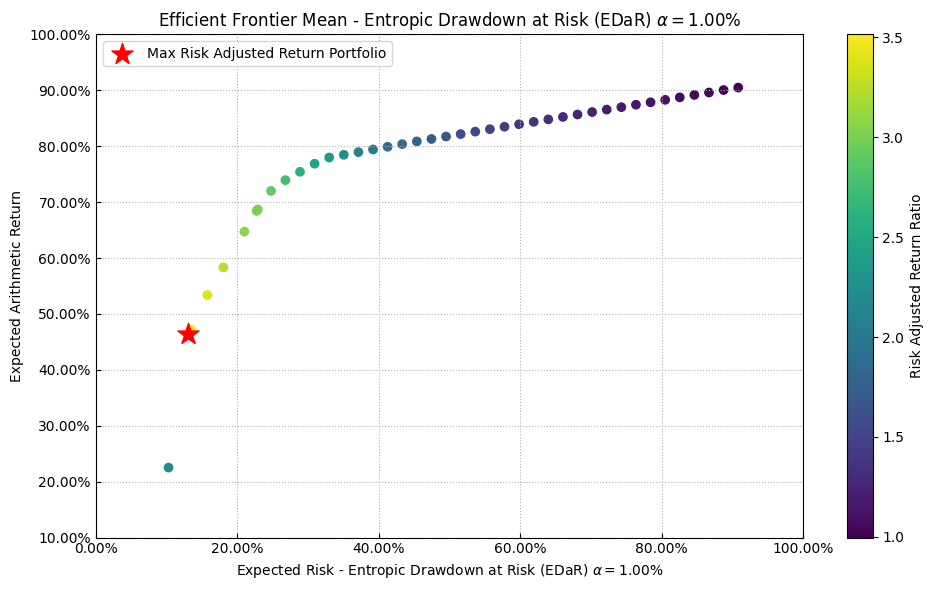

In [8]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.01, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

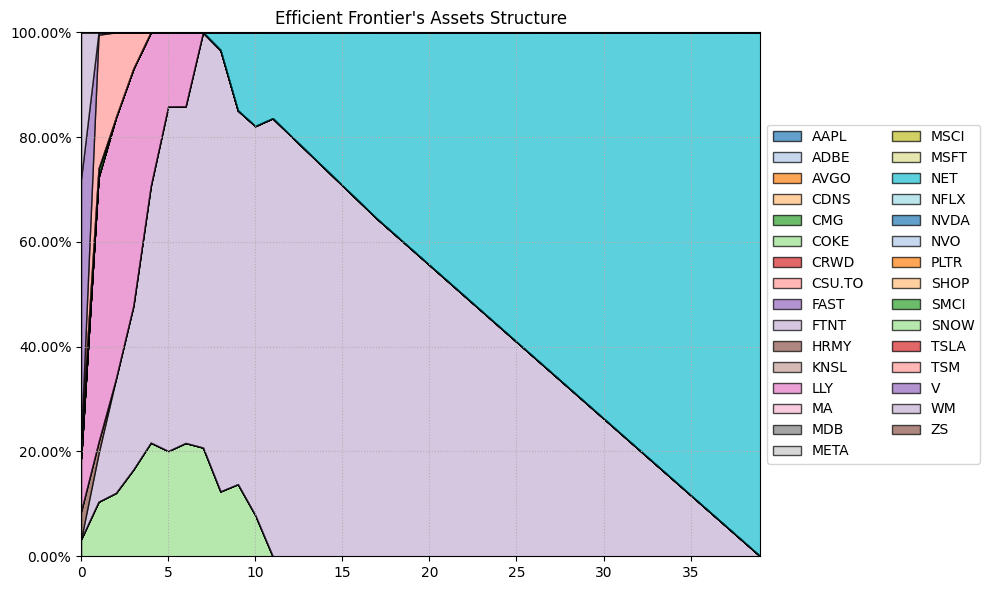

In [9]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 3. Estimating Risk Parity Portfolios for EDaR

### 3.1 Calculating the risk parity portfolio for EDaR.

The risk parity portfolio for the EDaR risk measure is the solution of the problem:

$$
\begin{aligned}
& \min_{w,\, z} & & \text{EDaR}_{\alpha}(r w) - b \ln(w)\\
& & & 1^{T}w = 0 \\
& & & w \geq 0 \\
\end{aligned}
$$

Where $w$ are the weights of assets, $b$ is the vector of constraints, by default is a vector of 1/(number of assets).

In [10]:
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,AAPL,ADBE,AVGO,CDNS,CMG,COKE,CRWD,CSU.TO,FAST,FTNT,...,NVO,PLTR,SHOP,SMCI,SNOW,TSLA,TSM,V,WM,ZS
weights,4.4534%,2.3978%,3.2672%,2.0087%,2.1666%,3.4114%,2.3581%,4.6452%,3.6170%,2.1632%,...,5.1284%,1.1923%,0.7484%,5.4951%,1.1927%,2.2116%,4.5664%,6.9879%,5.5455%,1.3740%


### 3.2 Plotting portfolio composition

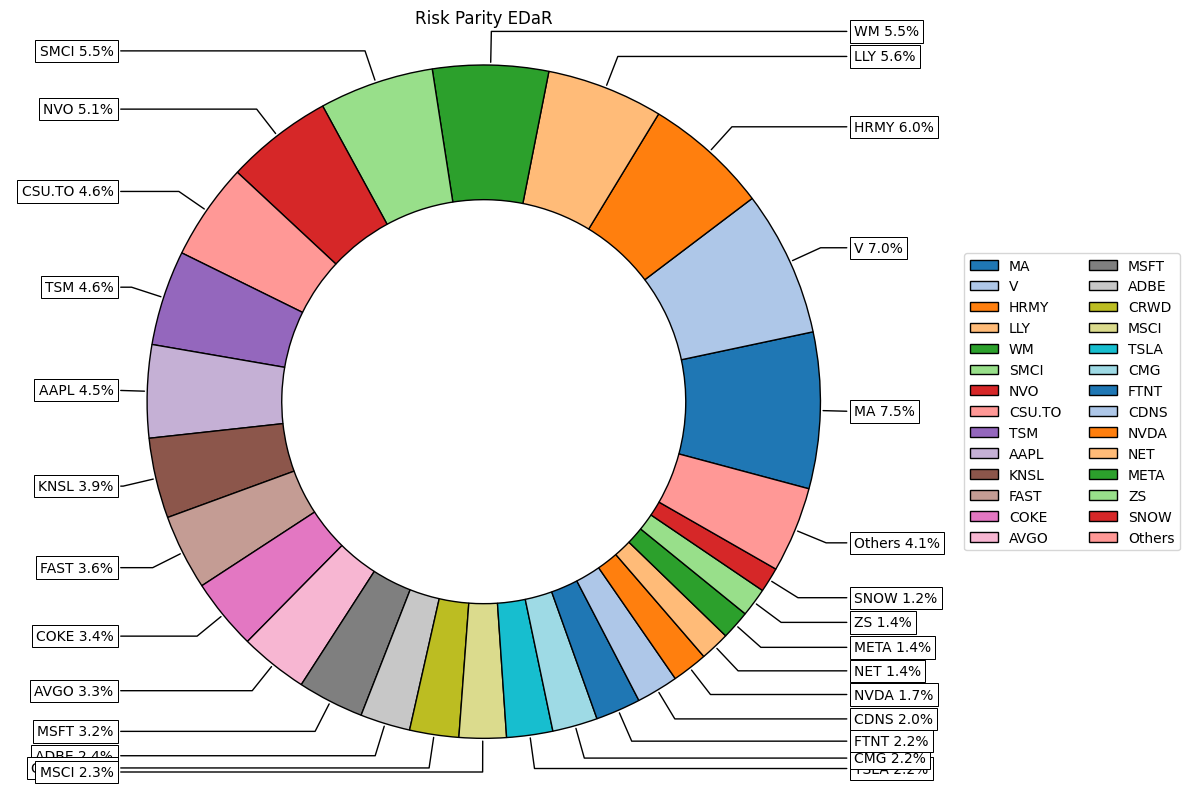

In [11]:
ax = rp.plot_pie(w=w_rp, title='Risk Parity EDaR', others=0.05, nrow=25, cmap = "tab20",
                 height=8, width=12, ax=None)

### 3.3 Plotting Risk Composition

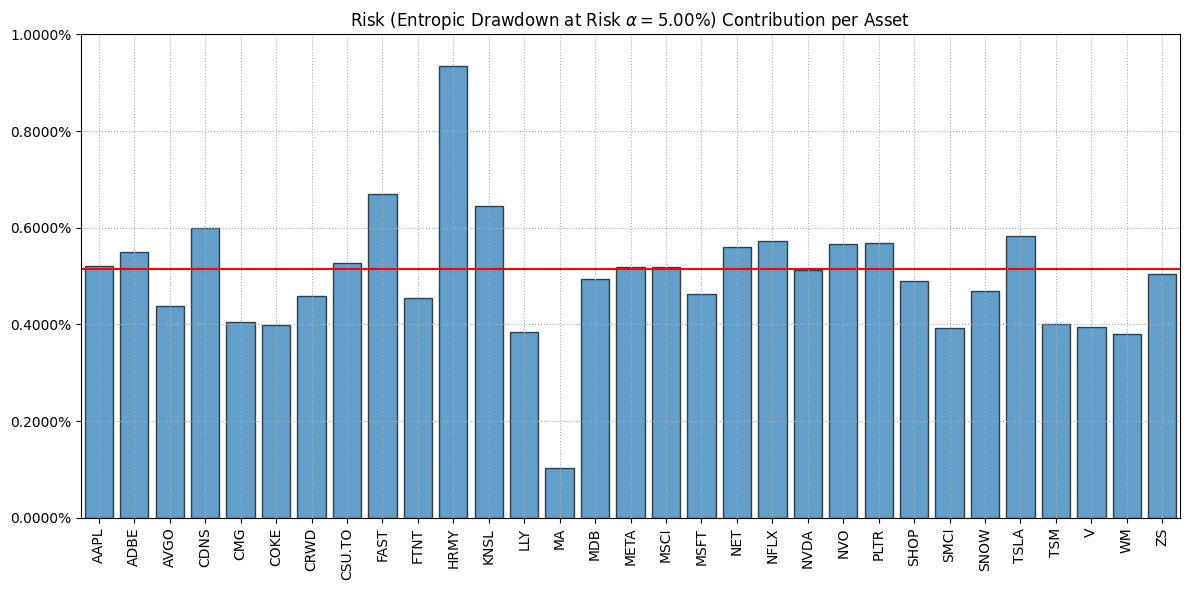

In [12]:
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.05,
                      color="tab:blue", height=6, width=12, ax=None)

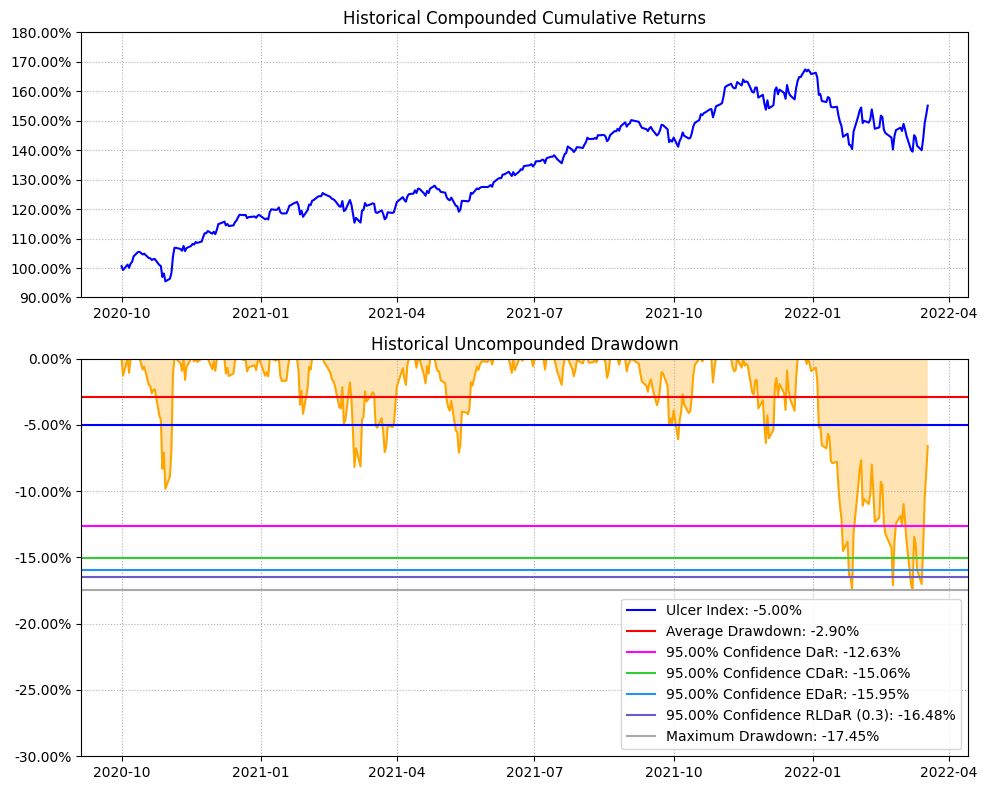

In [13]:
# Plotting the drawdown risk measures

ax = rp.plot_drawdown(returns=Y,
                      w=w_rp,
                      alpha=0.05,
                      height=8,
                      width=10,
                      height_ratios=[2, 3],
                      ax=None)